# Playground for Training
* Train, Save and Load weights

## Imports and config

In [85]:
import torch
import torch.nn as nn
import tiktoken

torch.set_printoptions(threshold=10, edgeitems=3, precision=2)
torch.manual_seed(42)

# See these files for details
%run "01. DataPreparation.ipynb"
%run "06. GPTModel.ipynb"

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

# From 01. DataPreparation
create_dataloader = create_dataloader

# From 06. GPTModel
model = GPTModel(GPT_CONFIG_124M) # From 06. GPTModel.ipynb
model.eval();  # Disable dropout during inference
generate_tokens = generate_tokens # From 06. GPTModel.ipynb

## Creating Training and Validation Data
* Generates test Batches Input + Targets
* Drop_last removes incomplete last batches

In [86]:
def get_training_data(batch_size=2, context_length=4, stride=4, verbose=False):
    
    # Load sample text and create dataloader
    with open("00. Robins Small Text Sample.txt", "r", encoding="utf-8") as file:
        raw_text = file.read()
    
    tokenizer = tiktoken.get_encoding("gpt2")

    print(raw_text[:99], " ... ")
    total_characters = len(raw_text)
    total_tokens = len(tokenizer.encode(raw_text))
    print("Characters:", total_characters)
    print("Tokens:", total_tokens)

    # Train/validation ratio
    train_ratio = 0.90
    split_idx = int(train_ratio * len(raw_text))
    train_data = raw_text[:split_idx]
    val_data = raw_text[split_idx:]


    train_loader = create_dataloader(
        train_data,
        batch_size=2,
        context_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader(
        val_data,
        batch_size=2,
        context_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    return train_loader, val_loader

if '__file__' not in dir():
    train_loader, val_loader = get_training_data(verbose=True)
    
    print("\nInput: ([Batches, Context_Length]) Target: ([Batches, Context_Length])")
    print("\nTrain loader:")
    for x, y in train_loader:
        print(x.shape, y.shape)

    print("\nValidation loader:")
    for x, y in val_loader:
        print(x.shape, y.shape)

The Institute of Computational Excellence did not believe in budgets. It believed in innovation, ca  ... 
Characters: 24733
Tokens: 6746

Input: ([Batches, Context_Length]) Target: ([Batches, Context_Length])

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


## Determine Device and set model to device

In [87]:
if '__file__' not in dir():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using {device} device.")

    # Move model to device BEFORE using it
    model.to(device) #Add ; to remove model output

Using mps device.


## Helper
* `calc_loss_batch` Calculates cross-entropy loss on model output for given input and target batch
* `calc_loss_loader` Calculates average of cross-entropy loss over all batches in a dataloader
* `text_to_token_ids` Simply converty text into Token_IDS (adds batch dimension)
* `token_ids_to_text` Simply converty token_IDs into text (removes batch dimension)
* `evaluate_model` Used for training output. Sets model to eval and calculates loss on train and val data
* `generate_and_print_sample` Used for training output. Generates more tokens given a starting context

In [88]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_tokens(
            model=model, token_IDs=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


if '__file__' not in dir():
    train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, None)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

Training loss: 11.008652600375088
Validation loss: 11.06159782409668


## Training
* Performs training and outputs some evaluation results (see helper above)
* Untrained models tend to tokens that occurr often (bias) so first outputs are (., ", ')

In [89]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    
    # Initialize lists to track losses and tokens seen
    train_losses = []
    val_losses = []
    track_tokens_seen = []
    tokens_seen = 0 
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode  # good to always set flag
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

if '__file__' not in dir():
    tokenizer = tiktoken.get_encoding("gpt2")
    model = GPTModel(GPT_CONFIG_124M)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    num_epochs = 10
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=5, eval_iter=5,
        start_context="They brewed coffee.", tokenizer=tokenizer
    )

Ep 1 (Step 000000): Train loss 9.193, Val loss 9.405
Ep 1 (Step 000005): Train loss 7.570, Val loss 7.976
Ep 1 (Step 000010): Train loss 6.071, Val loss 7.336
They brewed coffee. “” ” ” ” ” ” ” ” ” ” ” ” ” ” ” ” 
Ep 2 (Step 000015): Train loss 5.604, Val loss 7.027
Ep 2 (Step 000020): Train loss 5.190, Val loss 6.952
They brewed coffee. “We” ” ” ” ” ” “I” ” ” ” “We” ” ” �
Ep 3 (Step 000025): Train loss 4.579, Val loss 7.079
Ep 3 (Step 000030): Train loss 4.177, Val loss 6.873
They brewed coffee. Sebastian” Sebastian” ” ” Sebastian” Sebastian“I. ” ” “I”  
Ep 4 (Step 000035): Train loss 3.261, Val loss 6.907
Ep 4 (Step 000040): Train loss 3.179, Val loss 6.925
They brewed coffee. Sebastian. “We’s voice filled the lab.” Sebastian, the mug.” Sebastian eyed the mug.” “We” �
Ep 5 (Step 000045): Train loss 2.715, Val loss 6.941
Ep 5 (Step 000050): Train loss 2.217, Val loss 6.954
They brewed coffee. Sebastian placed. Thorne.” “Patchwork?” Robin asked. They smiled. “I am to a a. “We” ” The dea

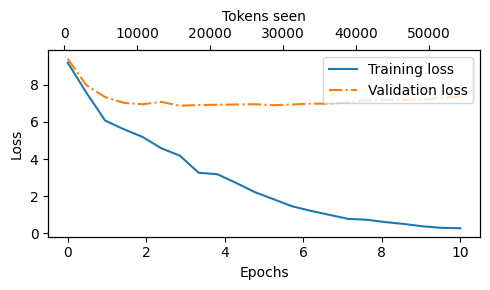

In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)